c:\Users\Kiel\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Chosen ARIMA order: (0, 1, 0), AIC=-2657.43


c:\Users\Kiel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Residual LSTM val MAE: 0.027352
Residual LSTM val RMSE: 0.037440


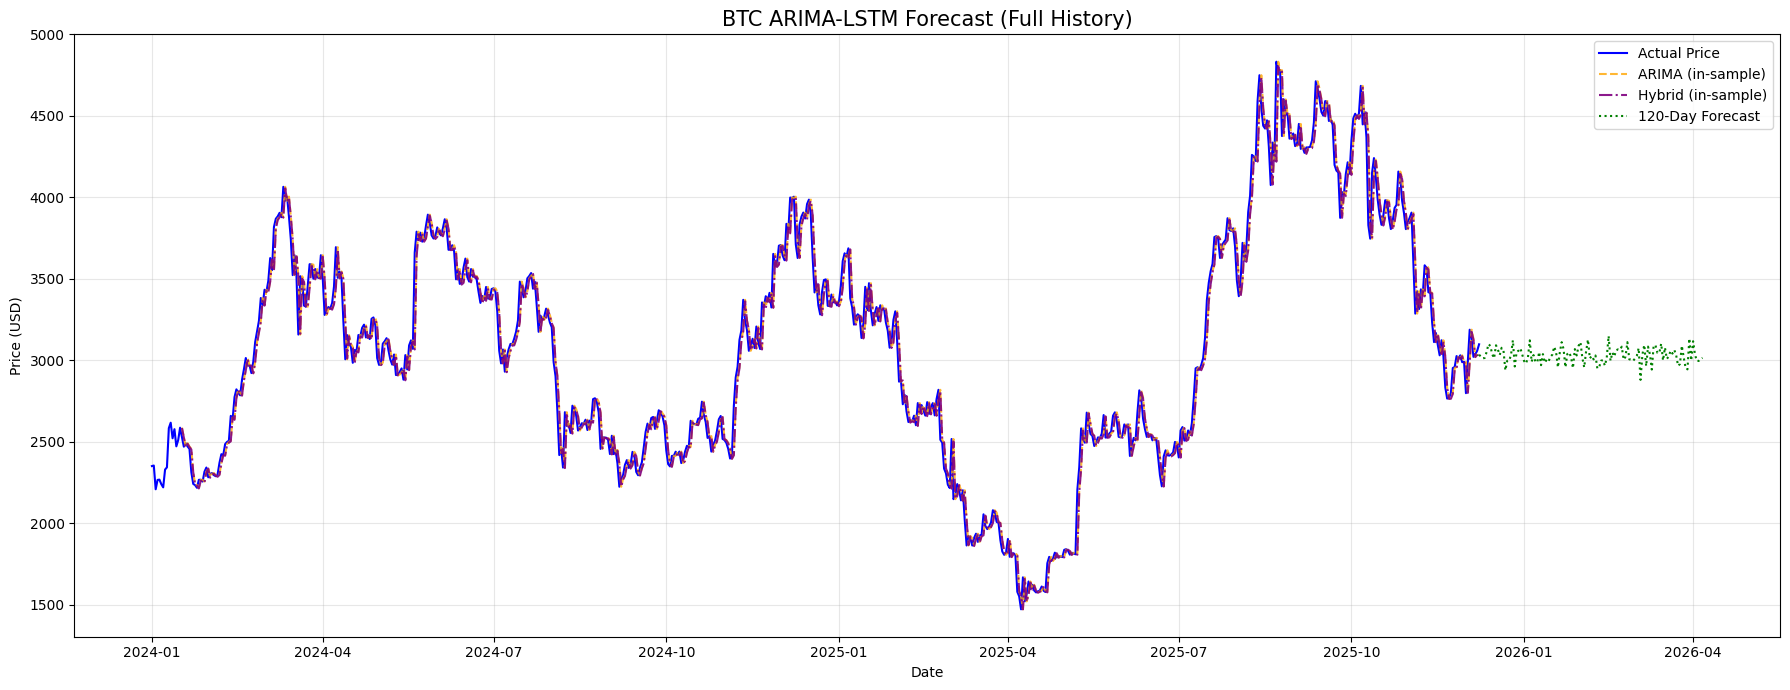

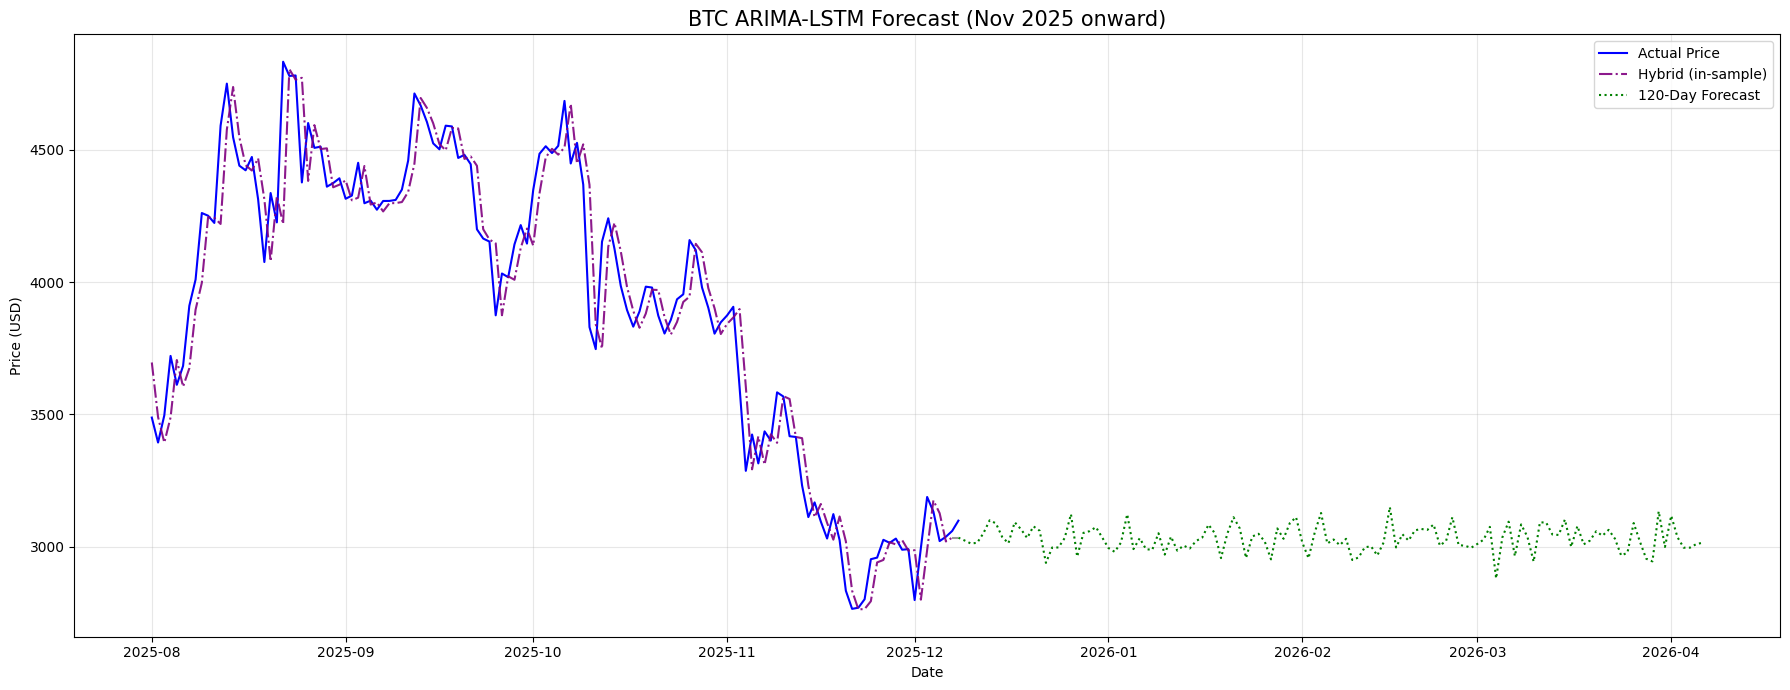


Forecast (first 10 days):
        date  forecast_price
0 2025-12-08     3034.591322
1 2025-12-09     3023.889222
2 2025-12-10     3012.534631
3 2025-12-11     3015.282617
4 2025-12-12     3051.268629
5 2025-12-13     3100.303671
6 2025-12-14     3088.684120
7 2025-12-15     3037.430598
8 2025-12-16     3013.452416
9 2025-12-17     3092.993572

Forecast (last 10 days):
          date  forecast_price
110 2026-03-28     2955.202395
111 2026-03-29     2945.051885
112 2026-03-30     3134.251916
113 2026-03-31     2999.552199
114 2026-04-01     3117.628416
115 2026-04-02     3036.526610
116 2026-04-03     2996.794769
117 2026-04-04     2996.914041
118 2026-04-05     3010.337267
119 2026-04-06     3015.412279


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# -----------------------------
# 1) Load & prep data
# -----------------------------
DATA_PATH = "dataset/price/eth_prices_2020_present.csv"
forecast_start = pd.Timestamp("2025-12-07")  # start forecasting after this point
forecast_horizon_days = 120
freq = "D"  # daily cadence
forecast_steps = forecast_horizon_days  # 1 step per day

# load
raw = pd.read_csv(DATA_PATH)
raw['timestamp'] = pd.to_datetime(raw['timestamp'])
raw = raw.sort_values('timestamp')
raw = raw.dropna(subset=['timestamp', 'price_eth'])
raw = raw.set_index('timestamp')
raw = raw[~raw.index.duplicated(keep='last')]

# scope: start from Jan 1, 2024
scope_start = pd.Timestamp("2024-01-01")
raw = raw.loc[raw.index >= scope_start]

# enforce regular daily grid, forward fill, then drop any leading NaN
series = raw.resample(freq).last().ffill()['price_eth'].dropna()
freq_td = pd.to_timedelta(1, unit='D')

# use log prices
log_series = np.log(series)
train_log = log_series.loc[:forecast_start]

# -----------------------------
# 2) Fit ARIMA on log prices (auto select p,q grid) without deterministic trend
# -----------------------------
best_aic = np.inf
best_order = None
best_model = None
for p in range(0, 4):
    for q in range(0, 4):
        try:
            m = ARIMA(
                train_log,
                order=(p, 1, q),
                trend='n',
                enforce_stationarity=False,
                enforce_invertibility=False,
            ).fit()
            if m.aic < best_aic:
                best_aic = m.aic
                best_order = (p, 1, q)
                best_model = m
        except Exception:
            continue

arima_result = best_model
arima_order = best_order
print(f"Chosen ARIMA order: {arima_order}, AIC={best_aic:.2f}")

# in-sample ARIMA predictions (log space)
arima_pred_log = np.asarray(arima_result.predict(start=train_log.index[0], end=train_log.index[-1], typ='levels'))
residuals = train_log.values - arima_pred_log

# -----------------------------
# 3) LSTM on residuals (sequence-to-one)
# -----------------------------
seq_len = 16  # 16 days lookback
scaler = MinMaxScaler()
residuals_scaled = scaler.fit_transform(residuals.reshape(-1, 1)).flatten()

X, y = [], []
for i in range(seq_len, len(residuals_scaled)):
    X.append(residuals_scaled[i-seq_len:i])
    y.append(residuals_scaled[i])
X = np.array(X).reshape(-1, seq_len, 1)
y = np.array(y)

val_size = max(1, int(0.2 * len(X)))
X_train, X_val = X[:-val_size], X[-val_size:]
y_train, y_val = y[:-val_size], y[-val_size:]

lstm = Sequential([
    LSTM(64, return_sequences=False, input_shape=(seq_len, 1)),
    Dense(1)
])
lstm.compile(optimizer="adam", loss="mse")
callbacks = [EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')]
lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=80, batch_size=32, verbose=0, callbacks=callbacks)

# in-sample residual predictions
pred_res_scaled = lstm.predict(X, verbose=0).flatten()
pred_residuals = scaler.inverse_transform(pred_res_scaled.reshape(-1,1)).flatten()

# build hybrid log prices; align after seq_len
arima_log_full = arima_pred_log
hybrid_log_full = np.concatenate([arima_log_full[:seq_len], arima_log_full[seq_len:] + pred_residuals])

hist_dates = train_log.index[seq_len:]
arima_hist = np.exp(arima_log_full[seq_len:])
hybrid_hist = np.exp(hybrid_log_full[seq_len:])

# -----------------------------
# 4) Forecast next 120 days
# -----------------------------
future_arima_log = arima_result.get_forecast(steps=forecast_steps).predicted_mean.values

# roll residuals forward with LSTM (no dampening)
future_residuals = []
window = residuals_scaled[-seq_len:].copy()
for _ in range(forecast_steps):
    lstm_in = window.reshape(1, seq_len, 1)
    pred_scaled = lstm.predict(lstm_in, verbose=0)[0,0]
    pred_res = scaler.inverse_transform([[pred_scaled]])[0,0]
    future_residuals.append(pred_res)
    window = np.append(window[1:], pred_scaled)

# add mild stochastic noise to avoid perfectly linear drift
future_residuals = np.array(future_residuals)
noise_scale = residuals.std() * 0.05
noise = np.random.normal(0, noise_scale, size=future_residuals.shape)
forecast_log = future_arima_log + future_residuals + noise
forecast_price = np.exp(forecast_log)
forecast_index = pd.date_range(start=train_log.index[-1] + freq_td, periods=forecast_steps, freq=freq)

# anchor forecast to last hybrid point for smooth transition
if len(hybrid_hist) > 0 and forecast_price[0] > 0:
    anchor_factor = hybrid_hist[-1] / forecast_price[0]
    forecast_price = forecast_price * anchor_factor

# -----------------------------
# 5) Evaluation on held-out val slice (rough)
# -----------------------------
from sklearn.metrics import mean_absolute_error, mean_squared_error
val_true = residuals[-val_size:]
val_pred = pred_residuals[-val_size:]
val_mae = mean_absolute_error(val_true, val_pred)
val_rmse = np.sqrt(mean_squared_error(val_true, val_pred))
print(f"Residual LSTM val MAE: {val_mae:.6f}")
print(f"Residual LSTM val RMSE: {val_rmse:.6f}")

# -----------------------------
# 6) Plots
# -----------------------------
plt.figure(figsize=(18,7))
plt.plot(series.index, series.values, label="Actual Price", color="blue")
plt.plot(hist_dates, arima_hist, "--", label="ARIMA (in-sample)", color="orange", alpha=0.8)
plt.plot(hist_dates, hybrid_hist, "-.", label="Hybrid (in-sample)", color="purple", alpha=0.9)
plt.plot(forecast_index, forecast_price, ":", label=f"{forecast_horizon_days}-Day Forecast", color="green")
plt.plot([hist_dates[-1], forecast_index[0]], [hybrid_hist[-1], forecast_price[0]], 'k--', alpha=0.4)
plt.title("BTC ARIMA-LSTM Forecast (Full History)", fontsize=15)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# zoom from Nov 2025 onward
zoom_start = pd.Timestamp("2025-08-01")
plt.figure(figsize=(18,7))
plt.plot(series.loc[zoom_start:].index, series.loc[zoom_start:].values, label="Actual Price", color="blue")
plt.plot(hist_dates[hist_dates>=zoom_start], hybrid_hist[hist_dates>=zoom_start], "-.", label="Hybrid (in-sample)", color="purple", alpha=0.9)
plt.plot(forecast_index, forecast_price, ":", label=f"{forecast_horizon_days}-Day Forecast", color="green")
plt.plot([hist_dates[-1], forecast_index[0]], [hybrid_hist[-1], forecast_price[0]], 'k--', alpha=0.4)
plt.title("BTC ARIMA-LSTM Forecast (Nov 2025 onward)", fontsize=15)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# print forecast values for inspection
forecast_df = pd.DataFrame({"date": forecast_index, "forecast_price": forecast_price})
print("\nForecast (first 10 days):")
print(forecast_df.head(10))
print("\nForecast (last 10 days):")
print(forecast_df.tail(10))


In [17]:
import os

# Make sure these variables already exist from your previous cells:
# series, hist_dates, hybrid_hist, forecast_index, forecast_price

os.makedirs("outputs", exist_ok=True)

# 1) In-sample (historical) hybrid predictions
in_sample_df = pd.DataFrame({
    "date": hist_dates,
    "actual_price": series.loc[hist_dates].values,
    "eth_hybrid_pred": hybrid_hist
})
in_sample_path = "outputs/eth_hybrid_in_sample.csv"
in_sample_df.to_csv(in_sample_path, index=False)
print(f"Saved in-sample predictions to {in_sample_path}")

# 2) Forecast (future) hybrid predictions
forecast_df = pd.DataFrame({
    "date": forecast_index,
    "eth_forecast_price": forecast_price
})
forecast_path = "outputs/eth_hybrid_forecast.csv"
forecast_df.to_csv(forecast_path, index=False)
print(f"Saved forecast predictions to {forecast_path}")

Saved in-sample predictions to outputs/eth_hybrid_in_sample.csv
Saved forecast predictions to outputs/eth_hybrid_forecast.csv


In [18]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# In-sample hybrid vs actual price metrics
hist_true = series.loc[hist_dates]
hist_pred = hybrid_hist
rmse = np.sqrt(mean_squared_error(hist_true, hist_pred))
mae = mean_absolute_error(hist_true, hist_pred)
mape = np.mean(np.abs((hist_true - hist_pred) / (hist_true + 1e-8)))
r2 = r2_score(hist_true, hist_pred)
pseudo_acc = 1 - mape
print(f"In-sample price metrics -> RMSE: {rmse:.6f}, MAE: {mae:.6f}, MAPE: {mape:.6f}, R2: {r2:.6f}, Pseudo Acc: {pseudo_acc:.6f}")


In-sample price metrics -> RMSE: 113.189201, MAE: 79.132109, MAPE: 0.025855, R2: 0.975512, Pseudo Acc: 0.974145
